## Run the first 4 cells to import data and create training and testing set

In [1]:
import numpy as np
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import SimpleRNN,LSTM, Dense, Activation
from keras.utils import to_categorical
#from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from UtilNNDL import *

Using TensorFlow backend.


In [2]:
"""
#file_path = '/home/carla/Downloads/project_datasets/project_datasets/'
file_path = '/home/kunal/Desktop/FinalProject/datasets/A01T_slice.mat'

A01T = h5py.File(file_path,'r')
data = np.copy(A01T['image'])
data = np.transpose(data,(0,2,1))
data = data[:,:,:22]
labels = np.copy(A01T['type'])
labels = labels[0,0:data.shape[0]:1]
labels = np.asarray(labels, dtype=np.int32)

a = data[:56]
b = data[57:]
data = np.vstack((a,b))
a = labels[:56]
b = labels[57:]
labels = np.hstack((a,b))
#enc = OneHotEncoder()
#enc_labels = enc.fit_transform(labels.reshape(-1,1)).toarray()
enc_labels = to_categorical(labels-769, num_classes=4)
print(enc_labels)

#scaler = StandardScaler()
#data = scaler.fit_transform(data,enc_labels)
"""

"\n#file_path = '/home/carla/Downloads/project_datasets/project_datasets/'\nfile_path = '/home/kunal/Desktop/FinalProject/datasets/A01T_slice.mat'\n\nA01T = h5py.File(file_path,'r')\ndata = np.copy(A01T['image'])\ndata = np.transpose(data,(0,2,1))\ndata = data[:,:,:22]\nlabels = np.copy(A01T['type'])\nlabels = labels[0,0:data.shape[0]:1]\nlabels = np.asarray(labels, dtype=np.int32)\n\na = data[:56]\nb = data[57:]\ndata = np.vstack((a,b))\na = labels[:56]\nb = labels[57:]\nlabels = np.hstack((a,b))\n#enc = OneHotEncoder()\n#enc_labels = enc.fit_transform(labels.reshape(-1,1)).toarray()\nenc_labels = to_categorical(labels-769, num_classes=4)\nprint(enc_labels)\n\n#scaler = StandardScaler()\n#data = scaler.fit_transform(data,enc_labels)\n"

In [3]:
"""
bs, t, f = data.shape
np.random.seed(42)
shuffle = np.random.choice(bs,bs,replace=False)

train_samples = 237
train_data = data[shuffle[:train_samples],:,:]
train_labels = enc_labels[shuffle[:train_samples]]
test_data = data[shuffle[train_samples:],:,:]
test_labels =enc_labels[shuffle[train_samples:]]

train_data = np.transpose(train_data,(0,2,1))
test_data = np.transpose(test_data,(0,2,1))

train_data,train_labels = create_window_data(train_data,train_labels)
test_data,test_labels = create_window_data(test_data,test_labels)

train_data = np.transpose(train_data,(0,2,1))
test_data = np.transpose(test_data,(0,2,1))

bs, t, f = train_data.shape
"""

'\nbs, t, f = data.shape\nnp.random.seed(42)\nshuffle = np.random.choice(bs,bs,replace=False)\n\ntrain_samples = 237\ntrain_data = data[shuffle[:train_samples],:,:]\ntrain_labels = enc_labels[shuffle[:train_samples]]\ntest_data = data[shuffle[train_samples:],:,:]\ntest_labels =enc_labels[shuffle[train_samples:]]\n\ntrain_data = np.transpose(train_data,(0,2,1))\ntest_data = np.transpose(test_data,(0,2,1))\n\ntrain_data,train_labels = create_window_data(train_data,train_labels)\ntest_data,test_labels = create_window_data(test_data,test_labels)\n\ntrain_data = np.transpose(train_data,(0,2,1))\ntest_data = np.transpose(test_data,(0,2,1))\n\nbs, t, f = train_data.shape\n'

In [4]:
#Prepare the data by taking out nans and dividing into test and train
#file_path = '/home/carla/Downloads/project_datasets/project_datasets/'
file_path = '/home/kunal/Desktop/FinalProject/datasets/'
train_data, test_data, train_labels, test_labels = prepare_data(file_path, 
                                                                num_test_samples = 50, 
                                                                verbose= False, 
                                                                return_all=True,
                                                                num_files =1)
print train_data.shape
print train_labels.shape
print test_data.shape
print test_labels.shape

(237, 22, 1000)
(237, 4)
(50, 22, 1000)
(50, 4)


In [5]:
#assist numerical stability
train_data = train_data*(1e6)
test_data = test_data*(1e6)

In [6]:
#Bandpass filter the data
train_data = train_data.swapaxes(1,2)
test_data = test_data.swapaxes(1,2)
print train_data.shape
print test_data.shape
for i,a in enumerate(train_data):
    train_data[i] = bandpass_cnt(a, 4, 38, 250, filt_order=3)
for i,a in enumerate(test_data):
    test_data[i] = bandpass_cnt(a, 4, 38, 250, filt_order=3)    
print train_data.shape
print test_data.shape

(237, 1000, 22)
(50, 1000, 22)
(237, 1000, 22)
(50, 1000, 22)


In [7]:
#Standardize the data
for i,a in enumerate(train_data):
    train_data[i] = exponential_running_standardize(a, factor_new=0.001, init_block_size=1000, eps=1e-4)
for i,a in enumerate(test_data):
    test_data[i] = exponential_running_standardize(a, factor_new=0.001, init_block_size=1000, eps=1e-4)
train_data = train_data.swapaxes(1,2)
test_data = test_data.swapaxes(1,2) 
print train_data.shape
print test_data.shape

(237, 22, 1000)
(50, 22, 1000)


In [8]:
#Augment the data into a bigger set by windowing
train_data_sliced, train_labels_sliced = create_window_data(train_data, train_labels, windows=10,window_size=512)
test_data_sliced, test_labels_sliced = create_window_data(test_data, test_labels, windows=10,window_size=512)

train_data_sliced = train_data_sliced.swapaxes(1,2)
test_data_sliced = test_data_sliced.swapaxes(1,2) 

bs,t,f = train_data_sliced.shape

print train_data_sliced.shape
print train_labels_sliced.shape
print test_data_sliced.shape
print test_labels_sliced.shape

(2370, 512, 22)
(2370, 4)
(500, 512, 22)
(500, 4)


# Everything from this point down is Testing

In [18]:
model = Sequential([
    LSTM(100, input_shape=(t,f)),
    Dense(32),
    Activation('relu'),
    #Dense(64),
    #Activation('relu'),
    Dense(32),
    Activation('relu'),
    Dense(4),
    Activation('softmax'),
])

model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

hist = model.fit(train_data,train_labels,epochs=15,validation_split=0.25,batch_size=32,verbose=0)
test_score = model.evaluate(test_data, test_labels, batch_size=32)

print(test_score)

plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Losses')

KeyboardInterrupt: 

## Modified VGGnet for this type of data

Modified VGG net to handle our input i.e. replace 2D with 1D, etc.(need to check dimensions and might need to transpose input to original shape)

Original VGGnet implementation can be found at hte address below

500/500 [==============================] - 0s 139us/step
[3.3455803813934328, 0.36599999904632569]


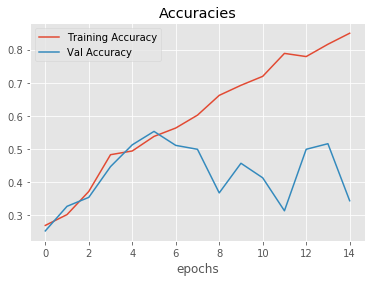

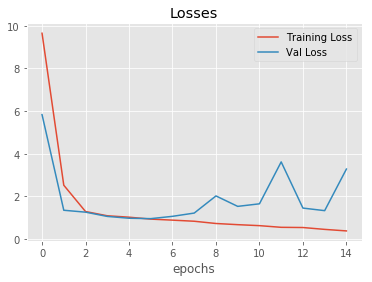

In [66]:
### VGGnet
# https://keras.io/getting-started/sequential-model-guide/#examples

import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization
from keras.optimizers import SGD

#norm_train = np.transpose((-np.mean(train_data,axis=2)+np.transpose(train_data,(2,0,1)))/np.std(train_data,axis=2),(1,2,0))
#norm_test = np.transpose((-np.mean(test_data,axis=2)+np.transpose(test_data,(2,0,1)))/np.std(test_data,axis=2),(1,2,0))

model = Sequential()
#model.add(LSTM(100, input_shape=(t,f)))
model.add(Conv1D(32, 4, activation='relu',input_shape=(t,f)))             #Originally 32 each
model.add(BatchNormalization())
model.add(Conv1D(32, 4, activation='relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.25))

model.add(Conv1D(64, 4, activation='relu'))                                    #Originally 64 each
model.add(BatchNormalization())
model.add(Conv1D(64, 4, activation='relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

hist = model.fit(train_data_sliced,train_labels_sliced,epochs=15,validation_split=0.25,batch_size=64,verbose=0)
test_score = model.evaluate(test_data_sliced, test_labels_sliced, batch_size=64)

print(test_score)
plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Losses')

Simple RNN model

500/500 [==============================] - 1s 1ms/step
[1.4065807809829711, 0.25600000023841857]


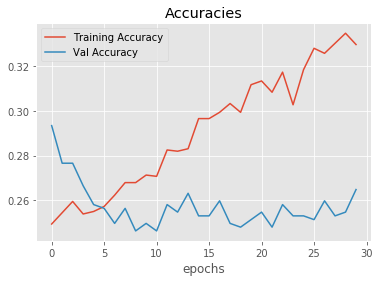

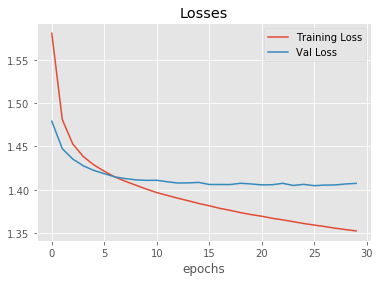

In [12]:
model = Sequential([
    SimpleRNN(64, input_shape=(t,f)),
    #Dense(32),
    #BatchNormalization(),
    #Activation('relu'),
    Dense(4),
    Activation('softmax'),
])

model.compile(optimizer = 'sgd',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

hist = model.fit(train_data_sliced,train_labels_sliced,epochs=30,validation_split=0.25,batch_size=64,verbose=0)
test_score = model.evaluate(test_data_sliced, test_labels_sliced, batch_size=32)

print(test_score)
plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Losses')

# CHRONONET PAPER

## C-RNN implementation (Figure 1b)

Train on 1777 samples, validate on 593 samples
Epoch 1/10
1777/1777 [==============================] - 17s 10ms/step - loss: 1.3835 - acc: 0.2673 - val_loss: 1.3483 - val_acc: 0.3626
Epoch 2/10
1777/1777 [==============================] - 7s 4ms/step - loss: 1.3011 - acc: 0.3675 - val_loss: 1.3396 - val_acc: 0.3086
Epoch 3/10
1777/1777 [==============================] - 7s 4ms/step - loss: 1.2308 - acc: 0.4142 - val_loss: 1.1744 - val_acc: 0.4401
Epoch 4/10
1777/1777 [==============================] - 7s 4ms/step - loss: 1.1597 - acc: 0.4474 - val_loss: 1.1623 - val_acc: 0.4081
Epoch 5/10
1777/1777 [==============================] - 7s 4ms/step - loss: 1.1090 - acc: 0.4615 - val_loss: 1.0412 - val_acc: 0.4992
Epoch 6/10
1777/1777 [==============================] - 7s 4ms/step - loss: 1.0594 - acc: 0.5048 - val_loss: 1.0397 - val_acc: 0.5126
Epoch 7/10
1777/1777 [==============================] - 7s 4ms/step - loss: 1.0264 - acc: 0.5144 - val_loss: 1.1548 - val_acc: 0.4469
Epoch 8/10
17

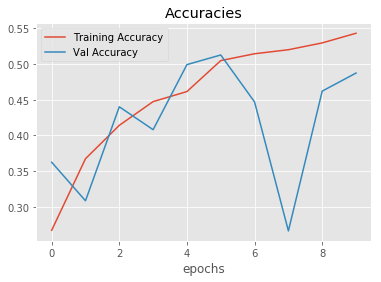

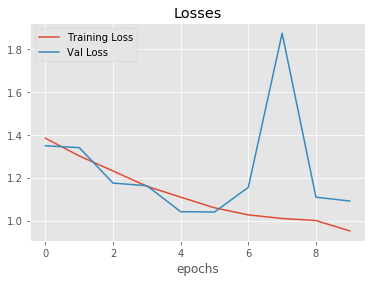

In [67]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization,GRU
from keras.optimizers import SGD
from keras.initializers import glorot_normal


model = Sequential()

model.add(Conv1D(32, 4, strides=2,activation='relu',input_shape=(t,f)))
model.add(Conv1D(32, 4, strides=2,activation='relu'))
model.add(Conv1D(32, 4, strides=2,activation='relu'))

#model.add(Flatten())

model.add(GRU(32,activation='tanh',return_sequences=True,kernel_initializer=glorot_normal()))
model.add(GRU(32,activation='tanh',return_sequences=True,kernel_initializer=glorot_normal()))
model.add(GRU(32,activation='tanh',return_sequences=True,kernel_initializer=glorot_normal()))
model.add(GRU(32,activation='tanh',kernel_initializer=glorot_normal()))

#model.add(Dense(64,activation = 'relu'))
#model.add(Dense(32,activation = 'relu'))
model.add(Dense(4, activation='softmax'))

#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(loss='categorical_crossentropy', optimizer=sgd)

#model.add()

model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

hist = model.fit(train_data_sliced,train_labels_sliced,epochs=10,validation_split=0.25,batch_size=64,verbose=1)
test_score = model.evaluate(test_data_sliced,test_labels_sliced, batch_size=64)
print(test_score)
plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Losses')

Implementation of Figure 1b but adding regularization structures like that found in VGGnet

Train on 1777 samples, validate on 593 samples
Epoch 1/15
1777/1777 [==============================] - 14s 8ms/step - loss: 1.3872 - acc: 0.2465 - val_loss: 1.3790 - val_acc: 0.3558
Epoch 2/15
1777/1777 [==============================] - 4s 2ms/step - loss: 1.2981 - acc: 0.3894 - val_loss: 1.1695 - val_acc: 0.4435
Epoch 3/15
1777/1777 [==============================] - 4s 2ms/step - loss: 1.0663 - acc: 0.4947 - val_loss: 1.0707 - val_acc: 0.4890
Epoch 4/15
1777/1777 [==============================] - 4s 2ms/step - loss: 0.9872 - acc: 0.5172 - val_loss: 1.0243 - val_acc: 0.4890
Epoch 5/15
1777/1777 [==============================] - 4s 2ms/step - loss: 0.9360 - acc: 0.5363 - val_loss: 1.0651 - val_acc: 0.4890
Epoch 6/15
1777/1777 [==============================] - 4s 2ms/step - loss: 0.8876 - acc: 0.5616 - val_loss: 1.0533 - val_acc: 0.5194
Epoch 7/15
1777/1777 [==============================] - 4s 2ms/step - loss: 0.8454 - acc: 0.5903 - val_loss: 1.1391 - val_acc: 0.4840
Epoch 8/15
177

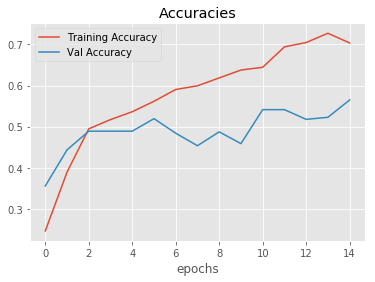

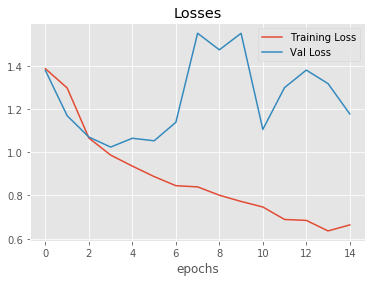

In [68]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization,GRU
from keras.optimizers import SGD

#norm_train = np.transpose((-np.mean(train_data,axis=2)+np.transpose(train_data,(2,0,1)))/np.std(train_data,axis=2),(1,2,0))
model = Sequential()

model.add(Conv1D(32, 4, strides=2,activation='relu',input_shape=(t,f)))
model.add(BatchNormalization())                            #From VGGnet
model.add(Conv1D(32, 4, strides=2,activation='relu'))
model.add(BatchNormalization())                            #From VGGnet
model.add(Conv1D(32, 4, strides=2,activation='relu'))
model.add(MaxPooling1D())                                  #From VGGnet
model.add(Dropout(0.25))                                   #From VGGnet
#model.add(Flatten())

model.add(GRU(32,activation='tanh',return_sequences=True))
model.add(GRU(32,activation='tanh',return_sequences=True))
model.add(GRU(32,activation='tanh',return_sequences=True))  #removed because of overfitting problem to small sample size
model.add(GRU(32,activation='tanh'))

#model.add(Dense(256, activation='relu'))                   #From VGGnet, but makes model suck
#model.add(Dropout(0.5))                                    #From VGGnet, but makes model suck
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(4, activation='softmax'))

# From VGGnet, works well for some reason
#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])

model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

#hist.history is a dictionary with all accs and losses
hist = model.fit(train_data_sliced,train_labels_sliced,epochs=15,validation_split=0.25,batch_size=64,verbose=1)
test_score = model.evaluate(test_data_sliced, test_labels_sliced, batch_size=16)
print(test_score)

plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Losses')


Replaced GRU with LSTM

Train on 1777 samples, validate on 593 samples
Epoch 1/15
1777/1777 [==============================] - 16s 9ms/step - loss: 1.3144 - acc: 0.3568 - val_loss: 1.1880 - val_acc: 0.4283
Epoch 2/15
1777/1777 [==============================] - 5s 3ms/step - loss: 0.9852 - acc: 0.5121 - val_loss: 1.0066 - val_acc: 0.4621
Epoch 3/15
1777/1777 [==============================] - 5s 3ms/step - loss: 0.9097 - acc: 0.5487 - val_loss: 0.9779 - val_acc: 0.5413
Epoch 4/15
1777/1777 [==============================] - 5s 3ms/step - loss: 0.8371 - acc: 0.6044 - val_loss: 0.9541 - val_acc: 0.5919
Epoch 5/15
1777/1777 [==============================] - 5s 3ms/step - loss: 0.8041 - acc: 0.6337 - val_loss: 1.2722 - val_acc: 0.4755
Epoch 6/15
1777/1777 [==============================] - 5s 3ms/step - loss: 0.7746 - acc: 0.6455 - val_loss: 1.0156 - val_acc: 0.5784
Epoch 7/15
1777/1777 [==============================] - 5s 3ms/step - loss: 0.7254 - acc: 0.6804 - val_loss: 1.0717 - val_acc: 0.5818
Epoch 8/15
177

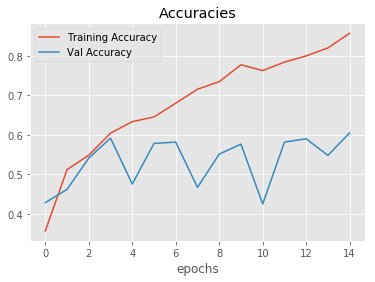

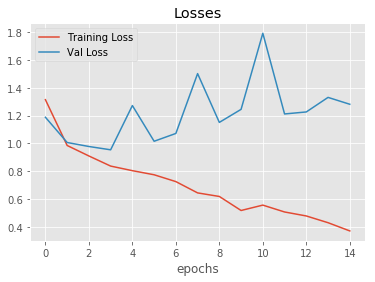

In [69]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization,GRU,LSTM
from keras.optimizers import SGD

#norm_train = np.transpose((-np.mean(train_data,axis=2)+np.transpose(train_data,(2,0,1)))/np.std(train_data,axis=2),(1,2,0))
model = Sequential()

model.add(Conv1D(32, 4, strides=2,activation='relu',input_shape=(t,f)))
model.add(BatchNormalization())                            #From VGGnet
model.add(Conv1D(32, 4, strides=2,activation='relu'))
model.add(BatchNormalization())                            #From VGGnet
model.add(Conv1D(32, 4, strides=2,activation='relu'))
model.add(MaxPooling1D())                                  #From VGGnet
model.add(Dropout(0.25))                                   #From VGGnet
#model.add(Flatten())

model.add(LSTM(32,activation='tanh',return_sequences=True))
model.add(LSTM(32,activation='tanh',return_sequences=True))
model.add(LSTM(32,activation='tanh',return_sequences=True))
model.add(LSTM(32,activation='tanh'))

#model.add(Dense(256, activation='relu'))                   #From VGGnet, but makes model suck
#model.add(Dropout(0.5))                                    #From VGGnet, but makes model suck
model.add(Dense(4, activation='softmax'))

# From VGGnet, works well for some reason
#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])

model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

#hist.history is a dictionary with all accs and losses
hist = model.fit(train_data_sliced,train_labels_sliced,epochs=15,validation_split=0.25,batch_size=64,verbose=1)
test_score = model.evaluate(test_data_sliced, test_labels_sliced, batch_size=64)

print "Test Results are ", test_score
plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Losses')


## IC-RNN

Train on 1777 samples, validate on 593 samples
Epoch 1/15
1777/1777 [==============================] - 19s 10ms/step - loss: 1.3920 - acc: 0.2876 - val_loss: 1.3459 - val_acc: 0.3440
Epoch 2/15
1777/1777 [==============================] - 8s 4ms/step - loss: 1.2776 - acc: 0.4012 - val_loss: 1.1440 - val_acc: 0.4857
Epoch 3/15
1777/1777 [==============================] - 8s 4ms/step - loss: 1.0378 - acc: 0.5194 - val_loss: 1.0521 - val_acc: 0.5177
Epoch 4/15
1777/1777 [==============================] - 8s 4ms/step - loss: 1.0068 - acc: 0.5279 - val_loss: 1.0073 - val_acc: 0.5329
Epoch 5/15
1777/1777 [==============================] - 8s 4ms/step - loss: 0.9075 - acc: 0.5763 - val_loss: 1.0471 - val_acc: 0.4806
Epoch 6/15
1777/1777 [==============================] - 8s 4ms/step - loss: 0.8892 - acc: 0.5763 - val_loss: 0.9707 - val_acc: 0.5160
Epoch 7/15
1777/1777 [==============================] - 8s 4ms/step - loss: 0.8196 - acc: 0.6213 - val_loss: 1.2897 - val_acc: 0.4992
Epoch 8/15
17

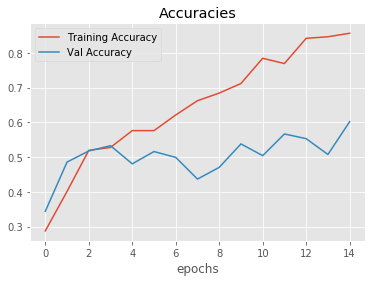

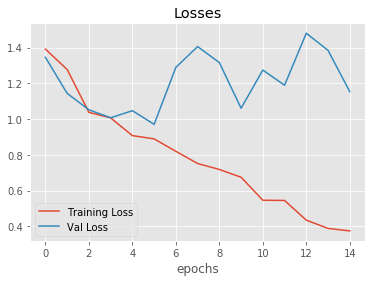

In [70]:
from keras.layers import Input,Dense,concatenate,Flatten,GRU,Conv1D
from keras.models import Model

inputs= Input(shape=(t,f))

# First Inception
tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(inputs)
tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(inputs)
tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(inputs)
x = concatenate([tower1,tower2,tower3],axis=2)

# Second Inception
tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(x)
tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(x)
tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(x)
x = concatenate([tower1,tower2,tower3],axis=2)

# Third Inception
tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(x)
tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(x)
tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(x)
x = concatenate([tower1,tower2,tower3],axis=2)


x = GRU(32,activation='tanh',return_sequences=True)(x)
x = GRU(32,activation='tanh',return_sequences=True)(x)
x = GRU(32,activation='tanh',return_sequences=True)(x)
x = GRU(32,activation='tanh')(x)


predictions = Dense(4,activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)

model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

#hist.history is a dictionary with all accs and losses
hist = model.fit(train_data_sliced,train_labels_sliced,epochs=15,validation_split=0.25,batch_size=64,verbose=1)
test_score = model.evaluate(test_data_sliced, test_labels_sliced, batch_size=64)

print "Test Results are ", test_score
plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Losses')


### IC-RNN Testing

Train on 1777 samples, validate on 593 samples
Epoch 1/15
1777/1777 [==============================] - 24s 13ms/step - loss: 1.3777 - acc: 0.2909 - val_loss: 1.2985 - val_acc: 0.3727
Epoch 2/15
1777/1777 [==============================] - 8s 5ms/step - loss: 1.1911 - acc: 0.4373 - val_loss: 1.1600 - val_acc: 0.4401
Epoch 3/15
1777/1777 [==============================] - 8s 5ms/step - loss: 1.0423 - acc: 0.4980 - val_loss: 1.1743 - val_acc: 0.4368
Epoch 4/15
1777/1777 [==============================] - 8s 5ms/step - loss: 0.9443 - acc: 0.5481 - val_loss: 1.0311 - val_acc: 0.5025
Epoch 5/15
1777/1777 [==============================] - 8s 5ms/step - loss: 0.9100 - acc: 0.5650 - val_loss: 1.0132 - val_acc: 0.5211
Epoch 6/15
1777/1777 [==============================] - 8s 5ms/step - loss: 0.8686 - acc: 0.5819 - val_loss: 1.0369 - val_acc: 0.5211
Epoch 7/15
1777/1777 [==============================] - 8s 5ms/step - loss: 0.8379 - acc: 0.6117 - val_loss: 1.1766 - val_acc: 0.4907
Epoch 8/15
17

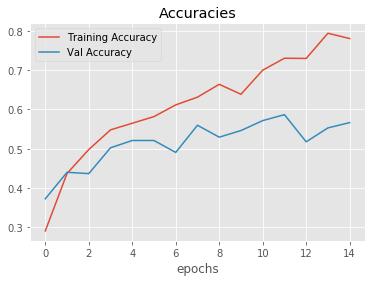

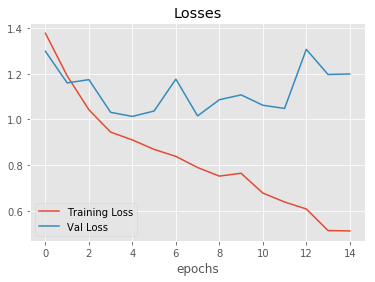

In [81]:
from keras.layers import Input,Dense,concatenate,Flatten,GRU,Conv1D,Bidirectional
from keras.models import Model

inputs= Input(shape=(t,f))

# First Inception
tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(inputs)
tower1 = BatchNormalization()(tower1)
tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(inputs)
tower2 = BatchNormalization()(tower2)
tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(inputs)
tower3 = BatchNormalization()(tower3)
#tower4 = MaxPooling1D()(inputs)
x = concatenate([tower1,tower2,tower3],axis=2)
x = Dropout(0.5)(x)

# Second Inception
tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(x)
tower1 = BatchNormalization()(tower1)
tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(x)
tower2 = BatchNormalization()(tower2)
tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(x)
tower3 = BatchNormalization()(tower3)
#tower4 = MaxPooling1D()(x)
x = concatenate([tower1,tower2,tower3],axis=2)
x = Dropout(0.5)(x)


# Third Inception
tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(x)
tower1 = BatchNormalization()(tower1)
tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(x)
tower2 = BatchNormalization()(tower2)
tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(x)
tower3 = BatchNormalization()(tower3)
#tower4 = MaxPooling1D()(x)
x = concatenate([tower1,tower2,tower3],axis=2)
x = Dropout(0.5)(x)


x = (GRU(32,activation='tanh',return_sequences=True))(x)
x = (GRU(32,activation='tanh',return_sequences=True))(x)
x = (GRU(32,activation='tanh',return_sequences=True))(x)
x = (GRU(32,activation='tanh'))(x)


predictions = Dense(4,activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)

model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

#hist.history is a dictionary with all accs and losses
hist = model.fit(train_data_sliced,train_labels_sliced,epochs=15,validation_split=0.25,batch_size=64,verbose=1)
test_score = model.evaluate(test_data_sliced, test_labels_sliced, batch_size=64)

print "Test Results are ", test_score
plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Losses')


## C-DRNN

Train on 1777 samples, validate on 593 samples
Epoch 1/20
1777/1777 [==============================] - 30s 17ms/step - loss: 1.3788 - acc: 0.2780 - val_loss: 1.3228 - val_acc: 0.3676
Epoch 2/20
1777/1777 [==============================] - 15s 8ms/step - loss: 1.2343 - acc: 0.4114 - val_loss: 1.2274 - val_acc: 0.4047
Epoch 3/20
1777/1777 [==============================] - 15s 8ms/step - loss: 1.1532 - acc: 0.4598 - val_loss: 1.0572 - val_acc: 0.4840
Epoch 4/20
1777/1777 [==============================] - 15s 8ms/step - loss: 1.0506 - acc: 0.5020 - val_loss: 0.9643 - val_acc: 0.5565
Epoch 5/20
1777/1777 [==============================] - 15s 9ms/step - loss: 0.9803 - acc: 0.5290 - val_loss: 0.9630 - val_acc: 0.5379
Epoch 6/20
1777/1777 [==============================] - 15s 9ms/step - loss: 0.9677 - acc: 0.5318 - val_loss: 1.0782 - val_acc: 0.4772
Epoch 7/20
1777/1777 [==============================] - 15s 8ms/step - loss: 0.9377 - acc: 0.5521 - val_loss: 0.9651 - val_acc: 0.5329
Epoch 8

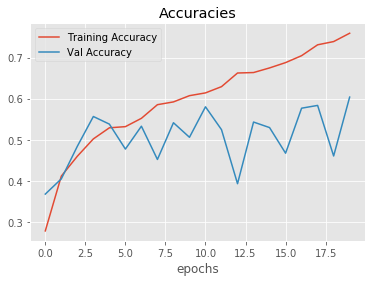

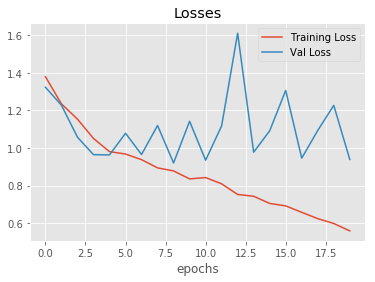

In [83]:
from keras.layers import Input,Dense,concatenate,Flatten,GRU,Conv1D
from keras.models import Model

inputs= Input(shape=(t,f))

x = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(inputs)
x = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(x)
x = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(x)

res1 = GRU(32,activation='tanh',return_sequences=True)(x)
res2 = GRU(32,activation='tanh',return_sequences=True)(res1)

res1_2 = concatenate([res1,res2],axis=2)

res3 = GRU(32,activation='tanh',return_sequences=True)(res1_2)

x = concatenate([res1,res2,res3])

x = GRU(32,activation='tanh')(x)
predictions = Dense(4,activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)
#print(model.summary())
model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

#hist.history is a dictionary with all accs and losses
hist = model.fit(train_data_sliced,train_labels_sliced,epochs=20,validation_split=0.25,batch_size=32,verbose=1)
test_score = model.evaluate(test_data_sliced, test_labels_sliced, batch_size=32)

print "Test Results are ", test_score
plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Losses')

### C-DRNN Testing

Train on 1777 samples, validate on 593 samples
Epoch 1/20
1777/1777 [==============================] - 32s 18ms/step - loss: 1.3716 - acc: 0.2983 - val_loss: 1.2838 - val_acc: 0.3710
Epoch 2/20
1777/1777 [==============================] - 15s 9ms/step - loss: 1.1575 - acc: 0.4519 - val_loss: 1.0632 - val_acc: 0.4772
Epoch 3/20
1777/1777 [==============================] - 15s 9ms/step - loss: 0.9854 - acc: 0.5155 - val_loss: 1.0235 - val_acc: 0.5126
Epoch 4/20
1777/1777 [==============================] - 15s 9ms/step - loss: 0.9412 - acc: 0.5391 - val_loss: 1.2226 - val_acc: 0.4570
Epoch 5/20
1777/1777 [==============================] - 15s 9ms/step - loss: 0.9109 - acc: 0.5504 - val_loss: 1.0529 - val_acc: 0.5076
Epoch 6/20
1777/1777 [==============================] - 15s 9ms/step - loss: 0.8823 - acc: 0.5746 - val_loss: 1.2038 - val_acc: 0.4806
Epoch 7/20
1777/1777 [==============================] - 15s 9ms/step - loss: 0.8374 - acc: 0.6095 - val_loss: 1.0551 - val_acc: 0.5346
Epoch 8

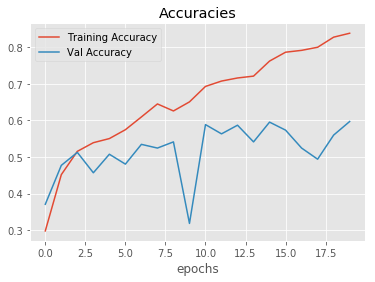

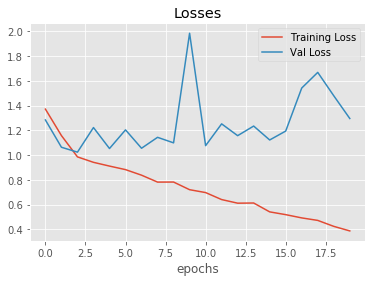

In [85]:
from keras.layers import Input,Dense,concatenate,Flatten,GRU,Conv1D,BatchNormalization,Dropout
from keras.models import Model

inputs= Input(shape=(t,f))

x = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(inputs)
x = BatchNormalization()(x)
x = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(x)
x = BatchNormalization()(x)
x = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(x)
x = Dropout(0.5)(x)

res1 = GRU(32,activation='tanh',return_sequences=True)(x)
res2 = GRU(32,activation='tanh',return_sequences=True)(res1)

res1_2 = concatenate([res1,res2],axis=2)

res3 = GRU(32,activation='tanh',return_sequences=True)(res2)

x = concatenate([res1,res2,res3])

x = GRU(32,activation='tanh')(x)
predictions = Dense(4,activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)

model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

#hist.history is a dictionary with all accs and losses
hist = model.fit(train_data_sliced,train_labels_sliced,epochs=20,validation_split=0.25,batch_size=32,verbose=1)
test_score = model.evaluate(test_data_sliced, test_labels_sliced, batch_size=32)

print "Test Results are ", test_score
plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Losses')


## ChronoNet

Train on 1777 samples, validate on 593 samples
Epoch 1/10
1777/1777 [==============================] - 24s 14ms/step - loss: 1.4201 - acc: 0.2487 - val_loss: 1.3753 - val_acc: 0.2968
Epoch 2/10
1777/1777 [==============================] - 8s 4ms/step - loss: 1.3475 - acc: 0.3343 - val_loss: 1.3522 - val_acc: 0.2732
Epoch 3/10
1777/1777 [==============================] - 8s 4ms/step - loss: 1.2141 - acc: 0.4237 - val_loss: 1.1789 - val_acc: 0.4553
Epoch 4/10
1777/1777 [==============================] - 8s 4ms/step - loss: 1.0286 - acc: 0.5346 - val_loss: 1.0001 - val_acc: 0.5278
Epoch 5/10
1777/1777 [==============================] - 8s 4ms/step - loss: 0.9063 - acc: 0.5841 - val_loss: 1.0072 - val_acc: 0.5093
Epoch 6/10
1777/1777 [==============================] - 8s 4ms/step - loss: 0.8369 - acc: 0.6398 - val_loss: 0.9714 - val_acc: 0.5278
Epoch 7/10
1777/1777 [==============================] - 8s 4ms/step - loss: 0.7677 - acc: 0.6742 - val_loss: 1.0621 - val_acc: 0.5413
Epoch 8/10
17

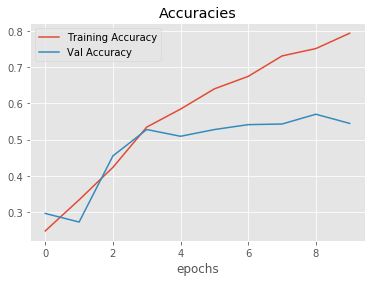

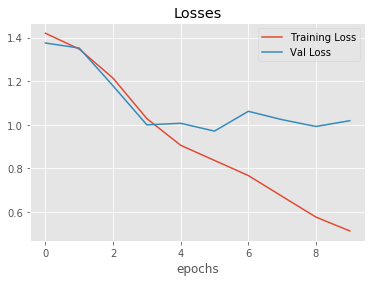

In [86]:
from keras.layers import Input,Dense,concatenate,Flatten,GRU,Conv1D
from keras.models import Model

inputs= Input(shape=(t,f))

# First Inception
tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(inputs)
tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(inputs)
tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(inputs)
x = concatenate([tower1,tower2,tower3],axis=2)

# Second Inception
tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(x)
tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(x)
tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(x)
x = concatenate([tower1,tower2,tower3],axis=2)

# Third Inception
tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(x)
tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(x)
tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(x)
x = concatenate([tower1,tower2,tower3],axis=2)

res1 = GRU(32,activation='tanh',return_sequences=True)(x)
res2 = GRU(32,activation='tanh',return_sequences=True)(res1)

res1_2 = concatenate([res1,res2],axis=2)

res3 = GRU(32,activation='tanh',return_sequences=True)(res1_2)

x = concatenate([res1,res2,res3])

x = GRU(32,activation='tanh')(x)
predictions = Dense(4,activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)

model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

#hist.history is a dictionary with all accs and losses
hist = model.fit(train_data_sliced,train_labels_sliced,epochs=10,validation_split=0.25,batch_size=64,verbose=1)
test_score = model.evaluate(test_data_sliced, test_labels_sliced, batch_size=64)

print "Testing Accuracy is", test_score
plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Losses')


### ChronoNet Model Testing

Train on 1777 samples, validate on 593 samples
Epoch 1/35
1777/1777 [==============================] - 27s 15ms/step - loss: 1.3932 - acc: 0.2763 - val_loss: 1.3671 - val_acc: 0.3019
Epoch 2/35
1777/1777 [==============================] - 21s 12ms/step - loss: 1.3891 - acc: 0.2667 - val_loss: 1.3377 - val_acc: 0.3170
Epoch 3/35
1777/1777 [==============================] - 19s 10ms/step - loss: 1.3627 - acc: 0.3011 - val_loss: 1.2871 - val_acc: 0.3491
Epoch 4/35
1777/1777 [==============================] - 19s 11ms/step - loss: 1.2695 - acc: 0.3810 - val_loss: 1.2826 - val_acc: 0.3946
Epoch 5/35
1777/1777 [==============================] - 18s 10ms/step - loss: 1.1743 - acc: 0.4429 - val_loss: 1.1171 - val_acc: 0.4772
Epoch 6/35
1777/1777 [==============================] - 18s 10ms/step - loss: 1.0549 - acc: 0.4806 - val_loss: 1.0663 - val_acc: 0.4924
Epoch 7/35
1777/1777 [==============================] - 18s 10ms/step - loss: 0.9997 - acc: 0.5048 - val_loss: 1.1001 - val_acc: 0.4907
E

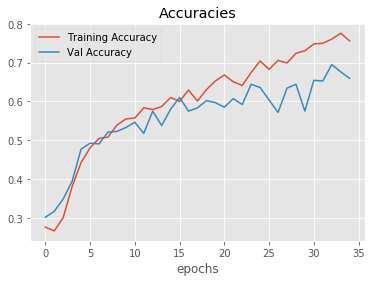

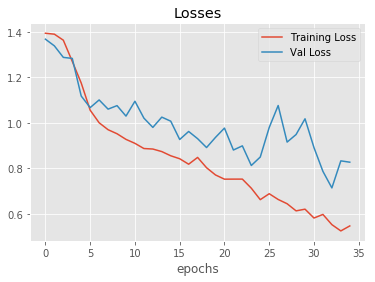

In [17]:
from keras.layers import Input,Dense,concatenate,Flatten,GRU,Conv1D
from keras.models import Model

inputs= Input(shape=(t,f))

# First Inception
tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(inputs)
tower1 = BatchNormalization()(tower1)
tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(inputs)
tower2 = BatchNormalization()(tower2)
tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(inputs)
tower3 = BatchNormalization()(tower3)
x = concatenate([tower1,tower2,tower3],axis=2)
x = Dropout(0.55)(x)

# Second Inception
tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(x)
tower1 = BatchNormalization()(tower1)
tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(x)
tower2 = BatchNormalization()(tower2)
tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(x)
tower3 = BatchNormalization()(tower3)
x = concatenate([tower1,tower2,tower3],axis=2)
x = Dropout(0.55)(x)

# Third Inception
tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(x)
tower1 = BatchNormalization()(tower1)
tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(x)
tower2 = BatchNormalization()(tower2)
tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(x)
tower3 = BatchNormalization()(tower3)
x = concatenate([tower1,tower2,tower3],axis=2)
x = Dropout(0.55)(x)

res1 = GRU(32,activation='tanh',return_sequences=True)(x)
res2 = GRU(32,activation='tanh',return_sequences=True)(res1)

res1_2 = concatenate([res1,res2],axis=2)

res3 = GRU(32,activation='tanh',return_sequences=True)(res1_2)

x = concatenate([res1,res2,res3])

x = GRU(32,activation='tanh')(x)
predictions = Dense(4,activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)

model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

#hist.history is a dictionary with all accs and losses
hist = model.fit(train_data_sliced,train_labels_sliced,epochs=35,validation_split=0.25,batch_size=64,verbose=1)
test_score = model.evaluate(test_data_sliced, test_labels_sliced, batch_size=64)

print "Testing Accuracy is", test_score
plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Losses')
